### All Imports and Setup

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt


In [ ]:
# Set random seed for reproducibility
SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    print("Using GPU")
    torch.cuda.manual_seed_all(SEED)

### Custom Moons

In [50]:
def custom_moons(n, noise):
    n_per_moon = n // 2
   
    # Generate the bottom moon (label 0)
    t0 = np.linspace(0, np.pi, n_per_moon)
    x0 = 1 - np.cos(t0)
    y0 = 0.5 - np.sin(t0)
    
    # Generate the top moon (label 1)
    t1 = np.linspace(0, np.pi, n_per_moon)
    x1 = 1 * np.cos(t1)
    y1 = 1 * np.sin(t1)
 
    
    # Combine moons
    X = np.vstack([np.column_stack([x1, y1]),
                   np.column_stack([x0, y0])])
    y = np.hstack([np.ones(n_per_moon), 
                   np.zeros(n_per_moon)])
    
    # Add noise
    noise = np.random.normal(0, noise, X.shape)
    X_noisy = X + noise
    
    # Shuffle the dataset
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    return X_noisy[indices], y[indices]


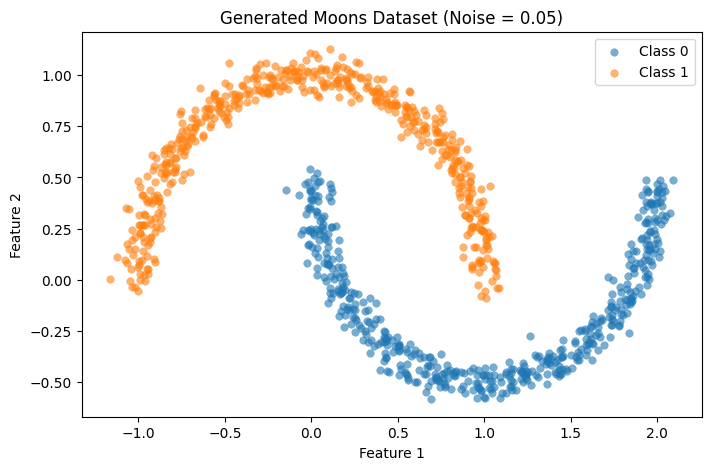

In [51]:
# Common scatter settings
scatter_kwargs = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)

# Example usage
X, y = custom_moons(1000, noise=0.05)
# Visualize the data
plt.figure(figsize=(8, 5))
plt.scatter(X[y==0, 0], X[y==0, 1], label="Class 0", alpha=0.6, s=30, linewidths=0.3)
plt.scatter(X[y==1, 0], X[y==1, 1], label="Class 1", alpha=0.6, s=30, linewidths=0.3)
plt.title("Generated Moons Dataset (Noise = 0.05)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()

### Generating Datasets

Train/Val set shape: (500, 2)
Test set (noise 0.1) shape: (500, 2)
Test set (noise 0.3) shape: (500, 2)


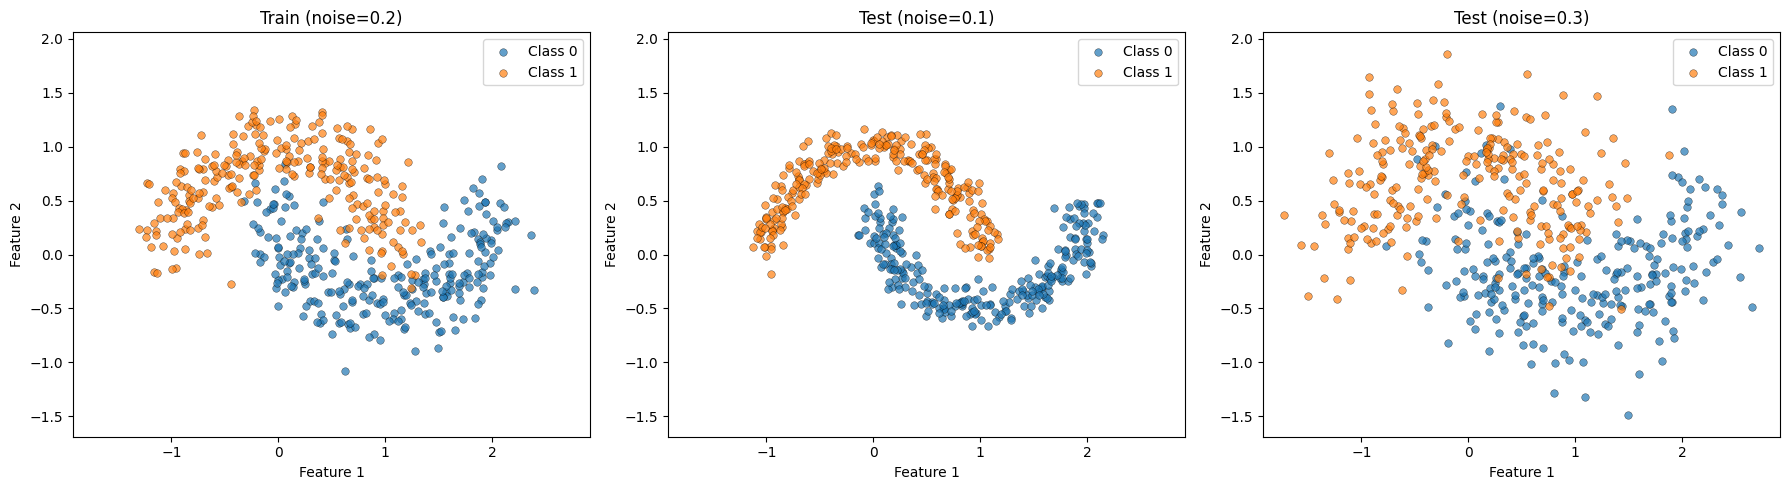

In [52]:
# Generate the datasets
X_train_full, y_train_full = custom_moons(n=500, noise=0.2)
X_test_01, y_test_01 = custom_moons(n=500, noise=0.1)
X_test_03, y_test_03 = custom_moons(n=500, noise=0.3)

print(f"Train/Val set shape: {X_train_full.shape}")
print(f"Test set (noise 0.1) shape: {X_test_01.shape}")
print(f"Test set (noise 0.3) shape: {X_test_03.shape}")

# Visualize Train and both Test sets side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Determine consistent axis limits for better comparison
all_X = np.vstack([X_train_full, X_test_01, X_test_03])
xmin, ymin = all_X.min(axis=0) - 0.2
xmax, ymax = all_X.max(axis=0) + 0.2

# Train
axes[0].scatter(X_train_full[y_train_full==0, 0], X_train_full[y_train_full==0, 1], label='Class 0', **scatter_kwargs)
axes[0].scatter(X_train_full[y_train_full==1, 0], X_train_full[y_train_full==1, 1], label='Class 1', **scatter_kwargs)
axes[0].set_title('Train (noise=0.2)')
axes[0].set_xlim(xmin, xmax)
axes[0].set_ylim(ymin, ymax)
axes[0].set_xlabel('Feature 1')
axes[0].set_ylabel('Feature 2')
axes[0].legend()

# Test noise=0.1
axes[1].scatter(X_test_01[y_test_01==0, 0], X_test_01[y_test_01==0, 1], label='Class 0', **scatter_kwargs)
axes[1].scatter(X_test_01[y_test_01==1, 0], X_test_01[y_test_01==1, 1], label='Class 1', **scatter_kwargs)
axes[1].set_title('Test (noise=0.1)')
axes[1].set_xlim(xmin, xmax)
axes[1].set_ylim(ymin, ymax)
axes[1].set_xlabel('Feature 1')
axes[1].set_ylabel('Feature 2')
axes[1].legend()

# Test noise=0.3
axes[2].scatter(X_test_03[y_test_03==0, 0], X_test_03[y_test_03==0, 1], label='Class 0', **scatter_kwargs)
axes[2].scatter(X_test_03[y_test_03==1, 0], X_test_03[y_test_03==1, 1], label='Class 1', **scatter_kwargs)
axes[2].set_title('Test (noise=0.3)')
axes[2].set_xlim(xmin, xmax)
axes[2].set_ylim(ymin, ymax)
axes[2].set_xlabel('Feature 1')
axes[2].set_ylabel('Feature 2')
axes[2].legend()

plt.tight_layout()
plt.show()

### Data Preprocessing

In [53]:
# Create validation split (20% of the 500 points)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, 
    test_size=0.2, 
    stratify=y_train_full #ensures class balance in split
)

print(f"Final training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")


Final training set shape: (400, 2)
Validation set shape: (100, 2)


In [54]:
# Standardize x using train statistics
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) # Fit ONLY on X_train

# Transform all other sets
X_val_scaled = scaler.transform(X_val)
X_test_01_scaled = scaler.transform(X_test_01)
X_test_03_scaled = scaler.transform(X_test_03)

# Convert to PyTorch Tensors
# We need y to be (batch_size, 1) and float for BCEWithLogitsLoss
X_train_t = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)

X_val_t = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_t = torch.tensor(y_val, dtype=torch.float32).view(-1, 1)

X_test_01_t = torch.tensor(X_test_01_scaled, dtype=torch.float32)
y_test_01_t = torch.tensor(y_test_01, dtype=torch.float32).view(-1, 1)

X_test_03_t = torch.tensor(X_test_03_scaled, dtype=torch.float32)
y_test_03_t = torch.tensor(y_test_03, dtype=torch.float32).view(-1, 1)

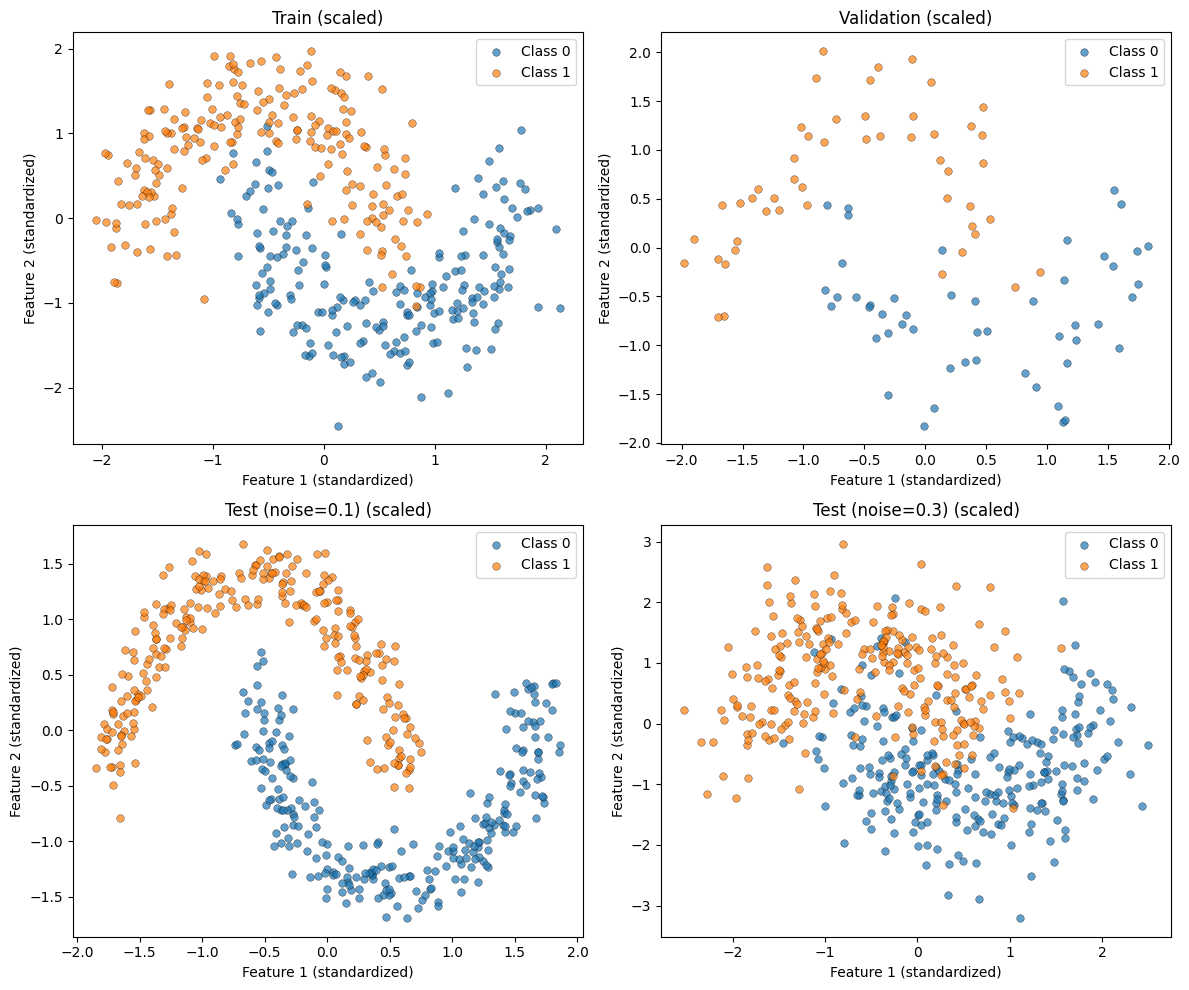

In [55]:
# Visualize the SCALED datasets (Train / Val / Test 0.1 / Test 0.3)
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Unpack axes for convenience
ax00, ax01, ax10, ax11 = axes.flatten()

# Use same scatter settings as before
scatter_kwargs_scaled = dict(alpha=0.7, s=30, edgecolor='k', linewidths=0.3)

# Train (scaled)
ax00.scatter(X_train_scaled[y_train==0, 0], X_train_scaled[y_train==0, 1], label='Class 0', **scatter_kwargs_scaled)
ax00.scatter(X_train_scaled[y_train==1, 0], X_train_scaled[y_train==1, 1], label='Class 1', **scatter_kwargs_scaled)
ax00.set_title('Train (scaled)')
ax00.set_xlabel('Feature 1 (standardized)')
ax00.set_ylabel('Feature 2 (standardized)')
ax00.legend()

# Validation (scaled)
ax01.scatter(X_val_scaled[y_val==0, 0], X_val_scaled[y_val==0, 1], label='Class 0', **scatter_kwargs_scaled)
ax01.scatter(X_val_scaled[y_val==1, 0], X_val_scaled[y_val==1, 1], label='Class 1', **scatter_kwargs_scaled)
ax01.set_title('Validation (scaled)')
ax01.set_xlabel('Feature 1 (standardized)')
ax01.set_ylabel('Feature 2 (standardized)')
ax01.legend()

# Test noise=0.1 (scaled)
ax10.scatter(X_test_01_scaled[y_test_01==0, 0], X_test_01_scaled[y_test_01==0, 1], label='Class 0', **scatter_kwargs_scaled)
ax10.scatter(X_test_01_scaled[y_test_01==1, 0], X_test_01_scaled[y_test_01==1, 1], label='Class 1', **scatter_kwargs_scaled)
ax10.set_title('Test (noise=0.1) (scaled)')
ax10.set_xlabel('Feature 1 (standardized)')
ax10.set_ylabel('Feature 2 (standardized)')
ax10.legend()

# Test noise=0.3 (scaled)
ax11.scatter(X_test_03_scaled[y_test_03==0, 0], X_test_03_scaled[y_test_03==0, 1], label='Class 0', **scatter_kwargs_scaled)
ax11.scatter(X_test_03_scaled[y_test_03==1, 0], X_test_03_scaled[y_test_03==1, 1], label='Class 1', **scatter_kwargs_scaled)
ax11.set_title('Test (noise=0.3) (scaled)')
ax11.set_xlabel('Feature 1 (standardized)')
ax11.set_ylabel('Feature 2 (standardized)')
ax11.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Define the MLP
class SimpleMLP(nn.Module):
    def __init__(self, input_size=2, hidden_size=100, output_size=1):
        super(SimpleMLP, self).__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.layer2 = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.layer2(x) # No sigmoid, as we'll use BCEWithLogitsLoss
        return x

# Utility for AUROC
def get_auroc(model, X, y):
    model.eval() # Set model to evaluation mode
    with torch.no_grad():
        logits = model(X)
        probs = torch.sigmoid(logits)
        return roc_auc_score(y.numpy(), probs.numpy())

# Generalized Training Loop
def train_network(model, X_train, y_train, X_val, y_val, 
                  optimizer, criterion, 
                  n_epochs=1000, 
                  early_stopping_patience=None,
                  l1_lambda=0.0):
    
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = None

    for epoch in range(n_epochs):
        model.train() # Set model to training mode
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Add L1 penalty if applicable
        if l1_lambda > 0:
            l1_norm = sum(p.abs().sum() for p in model.parameters())
            loss += l1_lambda * l1_norm
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation check
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val)
            val_loss = criterion(val_outputs, y_val).item()
            
        # Early Stopping logic
        if early_stopping_patience:
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                best_model_state = model.state_dict() # Save the best model
            else:
                epochs_no_improve += 1
            
            if epochs_no_improve == early_stopping_patience:
                print(f"Early stopping at epoch {epoch+1}")
                model.load_state_dict(best_model_state) # Restore best model
                break
    
    if early_stopping_patience and best_model_state:
        model.load_state_dict(best_model_state) # Ensure best model is loaded

In [57]:
print("\n--- Training Model 1: MLP + Early Stopping ---")
model_es = SimpleMLP()
optimizer_es = optim.Adam(model_es.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

train_network(
    model=model_es,
    X_train=X_train_t, y_train=y_train_t,
    X_val=X_val_t, y_val=y_val_t,
    optimizer=optimizer_es,
    criterion=criterion,
    n_epochs=2000,
    early_stopping_patience=50
)

# Report robustness
auroc_es_val = get_auroc(model_es, X_val_t, y_val_t)
auroc_es_test1 = get_auroc(model_es, X_test_01_t, y_test_01_t)
auroc_es_test2 = get_auroc(model_es, X_test_03_t, y_test_03_t)

print(f"Validation AUROC: {auroc_es_val:.4f}")
print(f"Test (noise 0.1) AUROC: {auroc_es_test1:.4f}")
print(f"Test (noise 0.3) AUROC: {auroc_es_test2:.4f}")


--- Training Model 1: MLP + Early Stopping ---
Early stopping at epoch 332
Validation AUROC: 0.9972
Test (noise 0.1) AUROC: 1.0000
Test (noise 0.3) AUROC: 0.9613
Early stopping at epoch 332
Validation AUROC: 0.9972
Test (noise 0.1) AUROC: 1.0000
Test (noise 0.3) AUROC: 0.9613



--- Training Model 2: MLP + L1 Regularization ---
Training with L1 lambda = 1e-06
Training with L1 lambda = 3e-06
Training with L1 lambda = 3e-06
Training with L1 lambda = 1e-05
Training with L1 lambda = 1e-05
Training with L1 lambda = 3e-05
Training with L1 lambda = 3e-05
Training with L1 lambda = 0.0001
Training with L1 lambda = 0.0001
Training with L1 lambda = 0.0003
Training with L1 lambda = 0.0003


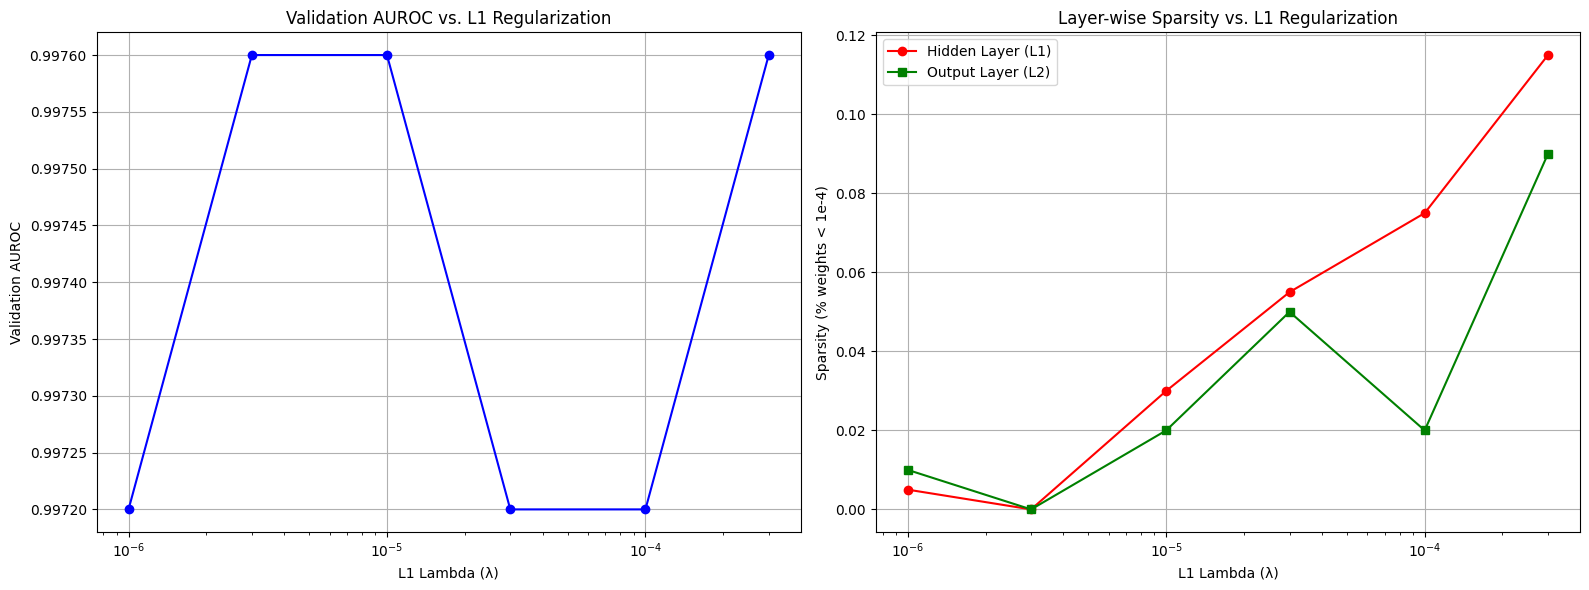

Best L1 Lambda based on Validation AUROC: 3e-06


In [ ]:
print("\n--- Training Model 2: MLP + L1 Regularization ---")
l1_lambdas = [1e-6, 3e-6, 1e-5, 3e-5, 1e-4, 3e-4]
val_aurocs_l1 = []
sparsity_l1 = [] # Layer 1 sparsity
sparsity_l2 = [] # Layer 2 sparsity

SPARSITY_THRESHOLD = 1e-4

for lam in l1_lambdas:
    model_l1 = SimpleMLP()
    optimizer_l1 = optim.Adam(model_l1.parameters(), lr=0.01) 
    criterion = nn.BCEWithLogitsLoss()
    
    print(f"Training with L1 lambda = {lam}")
    train_network(
        model=model_l1,
        X_train=X_train_t, y_train=y_train_t,
        X_val=X_val_t, y_val=y_val_t,
        optimizer=optimizer_l1,
        criterion=criterion,
        n_epochs=500, # Fixed epochs for comparison
        l1_lambda=lam
    )
    
    # Report Validation AUROC
    val_auroc = get_auroc(model_l1, X_val_t, y_val_t)
    val_aurocs_l1.append(val_auroc)

    # Report Layer-wise Sparsity
    l1_weights = model_l1.layer1.weight.data
    l2_weights = model_l1.layer2.weight.data
    
    sp1 = (l1_weights.abs() < SPARSITY_THRESHOLD).float().mean().item()
    sp2 = (l2_weights.abs() < SPARSITY_THRESHOLD).float().mean().item()
    
    sparsity_l1.append(sp1)
    sparsity_l2.append(sp2)

# Plotting the results for L1
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot Validation AUROC vs. Lambda
ax1.plot(l1_lambdas, val_aurocs_l1, 'bo-')
ax1.set_xscale('log')
ax1.set_xlabel('L1 Lambda (λ)')
ax1.set_ylabel('Validation AUROC')
ax1.set_title('Validation AUROC vs. L1 Regularization')
ax1.grid(True)


# Plot Sparsity vs. Lambda
ax2.plot(l1_lambdas, sparsity_l1, 'ro-', label='Hidden Layer (L1)')
ax2.plot(l1_lambdas, sparsity_l2, 'gs-', label='Output Layer (L2)')
ax2.set_xscale('log')
ax2.set_xlabel('L1 Lambda (λ)')
ax2.set_ylabel('Sparsity (% weights < 1e-4)')
ax2.set_title('Layer-wise Sparsity vs. L1 Regularization')
ax2.legend()
ax2.grid(True)


plt.tight_layout()
plt.show()

# Find the best L1 model and report test scores
best_l1_idx = np.argmax(val_aurocs_l1)
best_l1_lambda = l1_lambdas[best_l1_idx]
print(f"Best L1 Lambda based on Validation AUROC: {best_l1_lambda}")
# (You would typically retrain the model with this lambda, but for this exercise,
# we can use the one from the loop)

In [59]:
print("\n--- Training Model 3: MLP + L2 Regularization ---")
# L2 grid for weight_decay
l2_alphas = [1e-5, 1e-4, 1e-3, 1e-2, 0.1, 1.0] 
val_aurocs_l2 = []
best_l2_model = None
best_l2_auroc = -1
best_l2_alpha = None

for alpha in l2_alphas:
    model_l2 = SimpleMLP()
    # Add L2 penalty via weight_decay
    optimizer_l2 = optim.Adam(model_l2.parameters(), lr=0.01, weight_decay=alpha)
    criterion = nn.BCEWithLogitsLoss()
    
    print(f"Training with L2 alpha = {alpha}")
    # Use early stopping to find the best model for this alpha
    train_network(
        model=model_l2,
        X_train=X_train_t, y_train=y_train_t,
        X_val=X_val_t, y_val=y_val_t,
        optimizer=optimizer_l2,
        criterion=criterion,
        n_epochs=2000,
        early_stopping_patience=50
    )
    
    val_auroc = get_auroc(model_l2, X_val_t, y_val_t)
    val_aurocs_l2.append(val_auroc)
    
    if val_auroc > best_l2_auroc:
        best_l2_auroc = val_auroc
        best_l2_model = model_l2 # Save the model object
        best_l2_alpha = alpha

print(f"Best L2 alpha (weight_decay): {best_l2_alpha} with Val AUROC: {best_l2_auroc:.4f}")

# Report robustness of the best L2 model
auroc_l2_test1 = get_auroc(best_l2_model, X_test_01_t, y_test_01_t)
auroc_l2_test2 = get_auroc(best_l2_model, X_test_03_t, y_test_03_t)
print(f"Best L2 Model - Test (noise 0.1) AUROC: {auroc_l2_test1:.4f}")
print(f"Best L2 Model - Test (noise 0.3) AUROC: {auroc_l2_test2:.4f}")


--- Training Model 3: MLP + L2 Regularization ---
Training with L2 alpha = 1e-05
Early stopping at epoch 493
Training with L2 alpha = 0.0001
Early stopping at epoch 493
Training with L2 alpha = 0.0001
Early stopping at epoch 469
Training with L2 alpha = 0.001
Early stopping at epoch 469
Training with L2 alpha = 0.001
Early stopping at epoch 381
Training with L2 alpha = 0.01
Early stopping at epoch 381
Training with L2 alpha = 0.01
Early stopping at epoch 405
Training with L2 alpha = 0.1
Early stopping at epoch 66
Training with L2 alpha = 1.0
Early stopping at epoch 62
Best L2 alpha (weight_decay): 0.0001 with Val AUROC: 0.9976
Best L2 Model - Test (noise 0.1) AUROC: 1.0000
Best L2 Model - Test (noise 0.3) AUROC: 0.9613
Early stopping at epoch 405
Training with L2 alpha = 0.1
Early stopping at epoch 66
Training with L2 alpha = 1.0
Early stopping at epoch 62
Best L2 alpha (weight_decay): 0.0001 with Val AUROC: 0.9976
Best L2 Model - Test (noise 0.1) AUROC: 1.0000
Best L2 Model - Test (n

In [60]:
print("\n--- Training Model 4: Logistic Regression + Polynomial Features ---")

# Create polynomial features (degree 2)
poly = PolynomialFeatures(degree=2)

# Fit on the scaled training data
X_train_poly = poly.fit_transform(X_train_scaled)

# Transform all other sets
X_val_poly = poly.transform(X_val_scaled)
X_test_01_poly = poly.transform(X_test_01_scaled)
X_test_03_poly = poly.transform(X_test_03_scaled)

# Features will be [x1, x2, x1^2, x1*x2, x2^2]
print(f"Polynomial feature names: {poly.get_feature_names_out(['x1', 'x2'])}")
print(f"New training data shape: {X_train_poly.shape}")

# Train Logistic Regression
best_log_reg_model = None
best_log_reg_auroc = -1
best_C = None

for C in [0.01, 0.1, 1.0, 10, 100]:
    # Note: y_train is the 1D numpy array, not the tensor
    log_reg = LogisticRegression(C=C, random_state=SEED, max_iter=1000)
    log_reg.fit(X_train_poly, y_train)
    
    # Get probabilities for validation set
    y_val_probs = log_reg.predict_proba(X_val_poly)[:, 1]
    val_auroc = roc_auc_score(y_val, y_val_probs)
    
    if val_auroc > best_log_reg_auroc:
        best_log_reg_auroc = val_auroc
        best_log_reg_model = log_reg
        best_C = C

print(f"Best C: {best_C} with Val AUROC: {best_log_reg_auroc:.4f}")

# Report
y_test_01_probs = best_log_reg_model.predict_proba(X_test_01_poly)[:, 1]
y_test_03_probs = best_log_reg_model.predict_proba(X_test_03_poly)[:, 1]

auroc_lr_test1 = roc_auc_score(y_test_01, y_test_01_probs)
auroc_lr_test2 = roc_auc_score(y_test_03, y_test_03_probs)

print(f"LogReg Poly - Test (noise 0.1) AUROC: {auroc_lr_test1:.4f}")
print(f"LogReg Poly - Test (noise 0.3) AUROC: {auroc_lr_test2:.4f}")


--- Training Model 4: Logistic Regression + Polynomial Features ---
Polynomial feature names: ['1' 'x1' 'x2' 'x1^2' 'x1 x2' 'x2^2']
New training data shape: (400, 6)
Best C: 1.0 with Val AUROC: 0.9628
LogReg Poly - Test (noise 0.1) AUROC: 0.9631
LogReg Poly - Test (noise 0.3) AUROC: 0.9291


In [64]:
# Find the best lambda from our grid search
best_l1_idx = np.argmax(val_aurocs_l1)
best_l1_lambda = l1_lambdas[best_l1_idx]
# The best validation score is already known:
auroc_l1_val = val_aurocs_l1[best_l1_idx]

print(f"\n--- Finalizing Model 2 (L1) ---")
print(f"Best L1 Lambda found: {best_l1_lambda}")
print(f"Best L1 Validation AUROC: {auroc_l1_val:.4f}")

# Retrain the best L1 model (using early stopping for a robust result)
model_l1_best = SimpleMLP()
optimizer_l1_best = optim.Adam(model_l1_best.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

train_network(
    model=model_l1_best,
    X_train=X_train_t, y_train=y_train_t,
    X_val=X_val_t, y_val=y_val_t,
    optimizer=optimizer_l1_best,
    criterion=criterion,
    n_epochs=2000,
    early_stopping_patience=50, # Use early stopping for the final model
    l1_lambda=best_l1_lambda
)

# Get test scores for the best L1 model
auroc_l1_test1 = get_auroc(model_l1_best, X_test_01_t, y_test_01_t)
auroc_l1_test2 = get_auroc(model_l1_best, X_test_03_t, y_test_03_t)

display(f"Best L1 Model - Test (noise 0.1) AUROC: {auroc_l1_test1:.4f}")
display(f"Best L1 Model - Test (noise 0.3) AUROC: {auroc_l1_test2:.4f}")

# Create a dictionary to hold all the results
report_data = {
    "Validation AUROC (noise 0.2)": {
        "1. MLP + Early Stopping": auroc_es_val,
        "2. MLP + L1": auroc_l1_val,
        "3. MLP + L2": best_l2_auroc,
        "4. LogReg + PolyFeat": best_log_reg_auroc,
    },
    "Test AUROC (noise 0.1)": {
        "1. MLP + Early Stopping": auroc_es_test1,
        "2. MLP + L1": auroc_l1_test1,
        "3. MLP + L2": auroc_l2_test1,
        "4. LogReg + PolyFeat": auroc_lr_test1,
    },
    "Test AUROC (noise 0.3)": {
        "1. MLP + Early Stopping": auroc_es_test2,
        "2. MLP + L1": auroc_l1_test2,
        "3. MLP + L2": auroc_l2_test2,
        "4. LogReg + PolyFeat": auroc_lr_test2,
    }
}

# print
from IPython.display import Markdown, display
report_df = pd.DataFrame(report_data)
pd.set_option('display.float_format', '{:.4f}'.format)
display(Markdown(report_df.to_markdown(floatfmt=".4f")))


--- Finalizing Model 2 (L1) ---
Best L1 Lambda found: 3e-06
Best L1 Validation AUROC: 0.9976
Early stopping at epoch 449


'Best L1 Model - Test (noise 0.1) AUROC: 1.0000'

'Best L1 Model - Test (noise 0.3) AUROC: 0.9611'

|                         |   Validation AUROC (noise 0.2) |   Test AUROC (noise 0.1) |   Test AUROC (noise 0.3) |
|:------------------------|-------------------------------:|-------------------------:|-------------------------:|
| 1. MLP + Early Stopping |                         0.9972 |                   1.0000 |                   0.9613 |
| 2. MLP + L1             |                         0.9976 |                   1.0000 |                   0.9611 |
| 3. MLP + L2             |                         0.9976 |                   1.0000 |                   0.9613 |
| 4. LogReg + PolyFeat    |                         0.9628 |                   0.9631 |                   0.9291 |